In [1]:
# @title smulti-threaded sample analysis system

import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import pickle
from concurrent.futures import ProcessPoolExecutor
from sklearn.utils import shuffle
import random

try:
    import ipywidgets as widgets
except ImportError:
    !pip3 install ipywidgets
    import ipywidgets as widgets

from IPython.display import display, clear_output

fixed_timesteps = 1001
sub_dirs = ['1_4', '2_4', '3_4', '4_4', '5_4', '7_8']
FILES_TO_LOAD = 5

def get_length(file_path):
    y, sr = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=y, sr=sr)
    return mfccs.shape[1]

def determine_fixed_length(directory):
    file_paths = []

    for subdir in sub_dirs:
        files_to_load = os.listdir(os.path.join(directory, subdir))[:FILES_TO_LOAD]
        for file in tqdm(files_to_load):
            file_path = os.path.join(directory, subdir, file)
            file_paths.append(file_path)

    # Utilize multiprocessing for faster computation
    with ProcessPoolExecutor() as executor:
        lengths = list(executor.map(get_length, file_paths))

    return min(lengths)

def parallel_data_loader(directories):
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(parallel_load_and_preprocess, directories), total=len(directories)))
    return results

def load_and_preprocess_data_subdir(args):
    directory, subdir = args
    data = []
    labels = []
    
    # Only load up to 20 files per subdirectory
    files_to_load = os.listdir(os.path.join(directory, subdir))[:FILES_TO_LOAD]
    
    for file in files_to_load:
        file_path = os.path.join(directory, subdir, file)
        processed_data = load_audio(file_path)
        data.append(processed_data)
        label = sub_dirs.index(subdir)
        labels.append(label)
    
    return data, labels

def parallel_load_and_preprocess(directory):
    # Create a pool of processes
    pool = Pool(cpu_count())

    # Create a list of tasks
    tasks = [(directory, time_sig) for time_sig in sub_dirs]

    # Use imap_unordered to distribute the work among the processes
    results = list(tqdm(pool.imap_unordered(load_and_preprocess_data_subdir, tasks), total=len(tasks), mininterval=0.01))

    # Close the pool and wait for all processes to finish
    pool.close()
    pool.join()

    # Combine results
    combined_data = []
    combined_labels = []
    
    for data, labels in results:
        combined_data.extend(data)
        combined_labels.extend(labels)
    
    return combined_data, combined_labels


def adjust_fixed_length(features, timesteps):
    # If the array is 1-dimensional
    if len(features.shape) == 1:
        if features.shape[0] > timesteps:
            return features[:timesteps]
        elif features.shape[0] < timesteps:
            padding = np.zeros(timesteps - features.shape[0])
            return np.hstack((features, padding))
        return features
    # If the array is 2-dimensional
    else:
        # If the time axis of the 2D array is greater than timesteps, crop it.
        if features.shape[1] > timesteps:
            return features[:, :timesteps]
        # If the time axis of the 2D array is less than timesteps, pad it.
        elif features.shape[1] < timesteps:
            padding = np.zeros((features.shape[0], timesteps - features.shape[1]))
            return np.hstack((features, padding))
        return features

# Convert real-valued features to Poisson spike trains
def poisson_spike_encoding(data, duration=10, dt=1*ms):
    # Assuming data is normalized between 0 and 1
    rates = data * (1.0/dt)
    spikes = (np.random.rand(*data.shape) < rates*dt).astype(float)
    return spikes

def temporal_binning(data, bin_size):
    """
    Bins the data into chunks of bin_size and returns the average of each chunk.
    """
    # Split the data into chunks of bin_size
    binned_data = [np.mean(data[i:i+bin_size]) for i in range(0, len(data), bin_size)]
    return np.array(binned_data)

def rate_based_encoding(data, min_freq, max_freq):
    """
    Convert onset strengths to spike frequencies.
    data: The input data (should be normalized to [0, 1])
    min_freq: The minimum spike frequency (corresponds to data value of 0)
    max_freq: The maximum spike frequency (corresponds to data value of 1)
    Returns: Spike frequencies corresponding to input data
    """
    return min_freq + data * (max_freq - min_freq)

def extract_bpm_and_instrument(file_path):
    # Using \d+ to match one or more digits and [\d.]+ to match a float or integer pattern for noise.
    match = re.search(r"instrument_(\d+)_bpm_(\d+)_rotation_\d+_duration_(\d+)_noise_([\d.]+)", file_path)
    if match:
        instrument = match.group(1)
        bpm = match.group(2)
        duration = match.group(3)
        noise = match.group(4)
        return instrument, bpm, duration, noise
    return None, None, None, None

def moving_average(data, window_size):
    """Compute moving average"""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


def load_audio(file_path):
    y, sr = librosa.load(file_path, sr=22050)  # setting sr ensures all files are resampled to this rate
    return [y, sr, file_path]

# Process the audio file into desired features
# Process the audio file into desired features
def preprocess_audio(file_path):
    y, sr = librosa.load(file_path, sr=22050)  # setting sr ensures all files are resampled to this rate
    time_signature = file_path.split('/')[-2].replace('_', '/')
    instrument, bpm = extract_bpm_and_instrument(file_path)

    # Extracting onset strength
    onset_strength = librosa.onset.onset_strength(y=y, sr=sr)
    
    # Extracting tempogram
    tempogram = librosa.feature.tempogram(onset_envelope=onset_strength, sr=sr)
    
    # Extracting tempogram
    tempogram_cropped = librosa.feature.tempogram(onset_envelope=onset_strength[20:], sr=sr)
    
    # Adjust the time axis of each feature to fixed_timesteps
    onset_strength_fixed = adjust_fixed_length(onset_strength, fixed_timesteps)
    tempogram_fixed = adjust_fixed_length(tempogram, fixed_timesteps)

    # Stacking features horizontally
    combined_features = np.vstack(onset_strength)
    
    # Normalize to range [0, 1]
    encoded_features = (combined_features - np.min(combined_features)) / (np.max(combined_features) - np.min(combined_features))
    
        # Plotting
    plt.figure(figsize=(12, 14))
    plt.title('audio  with {time_signature} time signature, {bpm} bpm, and instrument {instrument}')

    rows = 6
    # 1. Raw audio
    plt.subplot(rows, 1, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title('Raw Audio')

    # 2. Onset strength
    plt.subplot(rows, 1, 2)
    plt.plot(onset_strength_fixed)
    plt.title('Onset Strength fixed size')
    
    # 2. Onset strength
    plt.subplot(rows, 1, 3)
    onset_strength_normalized = (onset_strength[20:] - np.min(onset_strength[20:])) / (np.max(onset_strength[20:]) - np.min(onset_strength[20:]))
    plt.plot(onset_strength_normalized)
    plt.title('Onset Strength normalized and cropped')
    
    # Add a plot for averaged onset strength
    plt.subplot(rows, 1, 4)
    averaged_onset = moving_average(onset_strength_normalized, window_size=5)  # using a window size of 10, adjust as needed
    plt.plot(averaged_onset)
    plt.title('Averaged Onset Strength')
    
    # 3. Tempogram
    plt.subplot(rows, 1, 5)
    librosa.display.specshow(tempogram_fixed, sr=sr, x_axis='time', y_axis='tempo')
    plt.title('Tempogram fixed')
    
        # 3. Tempogram
    plt.subplot(rows, 1, 6)
    librosa.display.specshow(tempogram_cropped, sr=sr, x_axis='time', y_axis='tempo')
    plt.title('Tempogram cropped')
    
    
    
    plt.tight_layout()
    plt.savefig(f'output_processing_noise_avg/{time_signature.replace("/", "_")}_BPM{bpm}_noise.png')
    
    return encoded_features[20:]


def count_files(directory):
    return sum([len(files) for _, _, files in os.walk(directory)])

# Current directory
directory = '.'

# Loop through all files in the current directory
for filename in os.listdir(directory):
    # Check if the filename ends with '.png' and contains 'spike_train'
    if filename.endswith('.png') and 'spike_train' in filename:
        # Construct the full file path
        filepath = os.path.join(directory, filename)
        
        # Remove the file
        os.remove(filepath)
        print(f"Deleted: {filename}", end='\r')
        

# checking shapes
print("Checking shapes...")
fixed_timesteps = determine_fixed_length('training_data_dirty_bpm')
print(fixed_timesteps)
# fixed_timesteps2 = determine_fixed_length('validation_data_dirty_bpm')
# print(fixed_timesteps2)
# fixed_timesteps = max(fixed_timesteps, fixed_timesteps2)


# 1. Load and preprocess data
print("Loading and preprocessing training data...")
directories = ['training_data_dirty_bpm', 'validation_data_dirty_bpm']
training_data_results, validation_data_results = parallel_data_loader(directories)

training_data, training_labels = training_data_results
validation_data, validation_labels = validation_data_results
print("\nDone with preprocessing!")


/usr/lib/python3/dist-packages/pythran/tables.py:4520: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  if not hasattr(numpy, method):
/usr/lib/python3/dist-packages/pythran/tables.py:4553: FutureWarning: In the future `np.bytes` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  obj = getattr(themodule, elem)


Checking shapes...


100%|██████████| 5/5 [00:00<00:00, 43690.67it/s]


518
Loading and preprocessing training data...


  0%|          | 0/2 [00:00<?, ?it/s]




100%|██████████| 6/6 [00:02<00:00,  2.52it/s]


100%|██████████| 2/2 [00:02<00:00,  1.44s/it]



Done with preprocessing!


In [3]:
class LIFNeuron:
    def __init__(self, 
                 tau_m=6.0,  # Membrane Time Constant: Determines the rate at which the membrane potential decays towards its resting value.
                 v_rest=0.0,  # Resting Potential: The stable value of the membrane potential when no external input is present.
                 v_threshold=0.7,  # Firing Threshold: The value of the membrane potential at which the neuron generates a spike.
                 v_reset=0.2,  # Reset Potential: The value to which the membrane potential is reset after a spike is generated.
                 r_m=0.9,  # Membrane Resistance: The effective resistance of the neuron's membrane, modulating the influence of incoming spikes.
                 dt=10.0,  # Time Step: Determines the granularity of the simulation time, influencing the speed of all dynamical variables.
                 adaptive_increase=0.0,  # Adaptive Increase: The value by which the firing threshold increases after each spike.
                 refractory_period=1  # Refractory Period: The number of time steps for which the neuron cannot fire after generating a spike.
                ):        
        self.tau_m = tau_m
        self.v_rest = v_rest
        self.v_threshold = v_threshold
        self.v_reset = v_reset
        self.r_m = r_m
        self.dt = dt
        self.v = v_rest
        self.adaptive_increase = adaptive_increase
        self.refractory_period = refractory_period
        self.refractory_counter = 0

    def constrain_value(self, value):
        return min(max(value, 0.0), 1.0)
    
    def update_voltage(self, i):
        dv = (-self.v + self.v_rest + self.r_m * i) / self.tau_m * self.dt
        self.v += dv
        self.v = self.constrain_value(self.v)
        
    def check_for_spike(self):
        spike = 0
        if self.v >= self.v_threshold:
            spike = 1
            self.v = self.v_reset
            
            if self.refractory_period > 0:
                self.refractory_counter = self.refractory_period
                
            if self.adaptive_increase > 0.0:
                self.v_threshold += self.adaptive_increase
                self.v_threshold = self.constrain_value(self.v_threshold)
        else:
            if self.adaptive_increase > 0.0:
                self.v_threshold = max(self.v_threshold - self.adaptive_increase, 1.0)
                self.v_threshold = self.constrain_value(self.v_threshold)
                
        return spike
    
    def step(self, i):
        if self.refractory_counter > 0:
            self.refractory_counter -= 1
            return 0

        self.update_voltage(i)
        
        # Constrain all relevant variables
        self.v_threshold = self.constrain_value(self.v_threshold)
        self.v_reset = self.constrain_value(self.v_reset)
        self.r_m = self.constrain_value(self.r_m)
        self.v_rest = self.constrain_value(self.v_rest)
        self.adaptive_increase = self.constrain_value(self.adaptive_increase)
        
        return self.check_for_spike()
        
    
def generate_lif_spikes(data, neuron):
    spikes = []
    potentials = []  # To store membrane potentials
    for i in data:
        spike = neuron.step(i)
        spikes.append(spike)
        potentials.append(neuron.v)  # Store the membrane potential after each step
    return np.array(spikes), np.array(potentials)

# Pre-process training data to filter into four different lists based on time_signature
training_data_1_4 = [item for item in training_data if item[2].split('/')[-2].replace('_', '/') == '1/4']
training_data_2_4 = [item for item in training_data if item[2].split('/')[-2].replace('_', '/') == '2/4']
training_data_3_4 = [item for item in training_data if item[2].split('/')[-2].replace('_', '/') == '3/4']
training_data_4_4 = [item for item in training_data if item[2].split('/')[-2].replace('_', '/') == '4/4']
training_data_5_4 = [item for item in training_data if item[2].split('/')[-2].replace('_', '/') == '5/4']
training_data_7_8 = [item for item in training_data if item[2].split('/')[-2].replace('_', '/') == '7/8']

#training_data_3_4 = np.asarray(training_data_3_4)
print(f"1/4: {len(training_data_1_4)}")
print(f"2/4: {len(training_data_2_4)}")
print(f"3/4: {len(training_data_3_4)}")
print(f"4/4: {len(training_data_4_4)}")
print(f"5/4: {len(training_data_5_4)}")
print(f"7/8: {len(training_data_7_8)}")

1/4: 5
2/4: 5
3/4: 5
4/4: 5
5/4: 5
7/8: 5


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Function that runs the simulation
def LIF(tau=10, t0=20, t1=40, t2=60, w=0.1, threshold=0.8, reset=0.0):
    # Spike times, keep sorted because it's more efficient to pop the last value off the list
    times = [t0, t1, t2, 80, 100, 110, 135, 150, 170, 180, 190]
    times.sort(reverse=True)
    # set some default parameters
    duration = 200 # total time in ms
    dt = 0.1 # timestep in ms
    alpha = np.exp(-dt/tau) # this is the factor by which V decays each time step
    V_rec = [] # list to record membrane potentials
    V = 0.0 # initial membrane potential
    T = np.arange(np.round(duration/dt))*dt # array of times
    spikes = [] # list to store spike times
    # run the simulation
    for t in T:
        V_rec.append(V) # record
        V *= alpha # integrate equations
        if times and t >= times[-1]: # if there has been an input spike
            V += w
            times.pop() # remove that spike from list
        if V > threshold: # if there should be an output spike
            V = reset
            spikes.append(t)
        V_rec.append(V) # record V after possible reset
    return T, V_rec, times, spikes

# Update function for the animation
# Update function for the animation to include smooth transitions
def update(frame):
    # Define the parameters to change over time
    tau = np.linspace(1, 20, num_frames)[frame]
    w = np.linspace(0.4, 0.8, num_frames)[frame]  # Weight of the input now varies as well

    # Calculate which time point we are at in the animation
    current_time = frame * duration / num_frames
    threshold = 0.8
    reset = 0.0

    # Run the LIF model with the current parameters up to the current_time
    T, V_rec, times, spikes = LIF(tau=tau, t0=20, t1=40, t2=60, w=w, threshold=threshold, reset=reset)

    # Filter T, V_rec, times, and spikes for the current frame
    T_frame = T[T <= current_time]
    V_rec_frame = V_rec[:len(T_frame)*2]
    times_frame = [t for t in times if t <= current_time]
    spikes_frame = [s for s in spikes if s <= current_time]

    # Update the plot
    ax.clear()
    for t in times_frame:
        ax.axvline(t, ls=':', c='b')
    ax.plot(np.repeat(T_frame, 2), V_rec_frame, '-k', lw=2)
    for s in spikes_frame:
        ax.axvline(s, ls='--', c='r')
    ax.axhline(threshold, ls='--', c='g')
    ax.set_xlim(0, 200)
    ax.set_ylim(-1, 2)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('V')
    
    # Text display of the current tau and weight values
    ax.text(0.95, 0.95, f'Tau: {tau:.2f}\nWeight: {w:.2f}', horizontalalignment='right',
            verticalalignment='top', transform=ax.transAxes, color='blue')



# Set up the figure for the animation
fig, ax = plt.subplots(figsize=(5, 4))
plt.close(fig)  # Close the figure to prevent it from showing now

# Number of frames in the animation
num_frames = 200

# Create the animation
ani = FuncAnimation(fig, update, frames=num_frames, blit=False)

# Save the animation
ani.save('lif_neuron_simulation.gif', writer='imagemagick', fps=25)  # Increase fps for a faster animation

In [4]:
    import scipy.signal
    from scipy.signal import savgol_filter


    def smooth_using_savgol(data, window_size, polynomial_order=3):
        return savgol_filter(data, window_size, polynomial_order)

    # Convert real-valued features to Poisson spike trains
    def poisson_spike_encoding(data, duration=10, dt=1*ms):
        # Assuming data is normalized between 0 and 1
        rates = data * (1.0/dt)
        spikes = (np.random.rand(*data.shape) < rates*dt).astype(float)
        return spikes

    def low_pass_filter(y, sr, cutoff_freq):
        nyq = 0.5 * sr  # Nyquist frequency
        normal_cutoff = cutoff_freq / nyq
        b, a = scipy.signal.butter(6, normal_cutoff, btype='low', analog=False)
        return scipy.signal.filtfilt(b, a, y)

    def high_pass_filter(y, sr, cutoff_freq):
        nyq = 0.5 * sr  # Nyquist frequency
        normal_cutoff = cutoff_freq / nyq
        b, a = scipy.signal.butter(6, normal_cutoff, btype='high', analog=False)
        return scipy.signal.filtfilt(b, a, y)

    def normalize_data(data):
        """Normalisiert eine Liste von Werten zwischen 0 und 1."""
        min_val = min(data)
        max_val = max(data)
        return [(val - min_val) / (max_val - min_val) for val in data]

    def plot_pixel_spectra_norm(item_no, window_size, tau_m, v_rest, v_threshold, v_reset, r_m, dt, high_pass_cutoff):
        y = training_data[item_no][0]
        sr = training_data[item_no][1]
        file_path = training_data[item_no][2]
        
                    # Apply a short fade-in
        # fade_in_time = 0.000  # in seconds
        # fade_in_samples = int(fade_in_time * sr)
        # fade_curve = np.linspace(0, 1, fade_in_samples)
        # y[:fade_in_samples] = y[:fade_in_samples] * fade_curve
        # Extract the MFCCs
        mfccs = librosa.feature.mfcc(y=y, sr=sr)
        # y = low_pass_filter(y, sr, low_pass_cutoff)
        # y = high_pass_filter(y, sr, high_pass_cutoff)
        
        time_signature = file_path.split('/')[-2].replace('_', '/')
        instrument, bpm, duration, noise = extract_bpm_and_instrument(file_path)
        print(f"time signature: {time_signature} BPM:{bpm} Noise:{noise} sampling rate: {sr} ", end='\r')

        # Extracting onset strength
        onset_strength = librosa.onset.onset_strength(y=y, sr=sr)
        
        # Extracting tempogram
        tempogram = librosa.feature.tempogram(onset_envelope=onset_strength, sr=sr)
        
        # Extracting Mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
        mel_spectrogram_8 = librosa.feature.melspectrogram(y=y, sr=8000)

        
        # Extracting tempogram
        tempogram_cropped = librosa.feature.tempogram(onset_envelope=onset_strength, sr=sr)
        
        # Adjust the time axis of each feature to fixed_timesteps
        onset_strength_fixed = adjust_fixed_length(onset_strength, fixed_timesteps)
        tempogram_fixed = adjust_fixed_length(tempogram, fixed_timesteps)

        # Stacking features horizontally
        combined_features = np.vstack(poisson_spike_encoding(onset_strength))
        
        # Normalize to range [0, 1]
        encoded_features = (combined_features - np.min(combined_features)) / (np.max(combined_features) - np.min(combined_features))
        
        onset_strength_normalized = (onset_strength - np.min(onset_strength)) / (np.max(onset_strength) - np.min(onset_strength))

        averaged_onset = moving_average(onset_strength_normalized, window_size=window_size)  # using a window size of 10, adjust as needed
        normalized_averaged_onset = normalize_data(averaged_onset)
        
        global_tempo = librosa.feature.rhythm.tempo(onset_envelope=onset_strength, sr=sr)[0]
        dtempo = librosa.feature.rhythm.tempo(onset_envelope=onset_strength, sr=sr, aggregate=None)
        
            # Plotting
        plt.figure(figsize=(12, 14))
        plt.title('audio  with {time_signature} time signature, {bpm} bpm, and instrument {instrument}')

        rows = 7
        # 1. Raw audio
        plt.subplot(rows, 1, 1)
        # Prepare time axes for raw audio and onset strength
        time_audio = np.linspace(0, len(y) / sr, len(y))
        time_onset = np.linspace(0, len(y) / sr, len(normalize_data(onset_strength)))

        # Plot raw audio
        plt.plot(time_audio, normalize_data(y), label='Raw Audio', alpha=0.7)

        # Plot onset strength (scaled)
        plt.plot(time_onset, normalize_data(onset_strength), label='spectral flux (scaled)', alpha=0.7, color='r')

        plt.legend()
        plt.xlabel('Time (s)')

        plt.title(f'Raw Audio and Spectral Flux, predicted BPM = {global_tempo}, actual BPM = {bpm}, instrument {instrument} and time signature {time_signature}')
        plt.legend()

        # Frequency spectrum
        plt.subplot(rows, 1, 2)
        librosa.display.specshow(mfccs, x_axis='time')
        plt.title('MFCC')
        plt.xlabel('Time (s)')
        plt.ylabel('MFCC Coefficients')
        
        
        # 3. Frequency spectrum after high-pass filtering
        plt.subplot(rows, 1, 5)
        y_high_pass = high_pass_filter(y, sr, high_pass_cutoff)
        fourier_high_pass = np.fft.fft(y_high_pass)
        n_high_pass = len(fourier_high_pass)
        frequencies_high_pass = np.fft.fftfreq(n_high_pass, 1/sr) 
        plt.plot(frequencies_high_pass[:n_high_pass//2], np.abs(fourier_high_pass)[:n_high_pass//2])
        plt.title(f'Frequency Spectrum after high-pass filter at {int(high_pass_cutoff)} Hz')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')

        
        # 2. Onset strength
        plt.subplot(rows, 1, 6)
        plt.plot(onset_strength_normalized, label='Onset Strength', alpha=0.7)
        poisson_encoded = poisson_spike_encoding(onset_strength_normalized.reshape(1,-1), dt=dt*ms)
        # Calculate the spike count
        spike_count = np.sum(poisson_encoded)
        plt.plot(poisson_encoded[0], label='Poisson Spike Train', linestyle=':', color='g')
        plt.title(f'Onset Strength fixed size with Poisson Spike Train - Spike Count: {int(spike_count)}')    
        plt.legend()
        # 2. Onset strength
        plt.subplot(rows, 1, 7)
        # plt.plot(onset_strength_normalized)
    
        lif_neuron = LIFNeuron(tau_m=tau_m, v_rest=v_rest, v_threshold=v_threshold, v_reset=v_reset, r_m=r_m, dt=dt)
        lif_spikes, _ = generate_lif_spikes(onset_strength_normalized, lif_neuron)
        spike_count = np.sum(lif_spikes)
            # 3. Onset strength with LIF spike train
        plt.plot(onset_strength_normalized, label='Onset Strength', alpha=0.7)
        plt.plot(lif_spikes, label='LIF Spike Train', linestyle='--', color='r')
        plt.title(f'Onset Strength with LIF Spike Train, Spike Count: {int(spike_count)}')
        #plt.legend()
        

        # 3. Tempogram
        # plt.subplot(rows, 1, 6)
        # librosa.display.specshow(tempogram_fixed, sr=sr, x_axis='time', y_axis='tempo')
        # plt.title('Tempogram fixed')
        
        # 7. Mel Spectrogram
        plt.subplot(rows, 1, 3)
        librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), y_axis='mel', x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel spectrogram')
        
        n_bands_to_keep = 80
        mel_spectrogram_reduced = mel_spectrogram[:n_bands_to_keep]
        
        plt.subplot(rows, 1, 4)
        librosa.display.specshow(librosa.power_to_db(mel_spectrogram_reduced, ref=np.max), y_axis='mel', x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel spectrogram reduced')
        
        print("Dimensions of mel_spectrogram:", mel_spectrogram.shape)
        print("Dimensions of mel_spectrogram_reduced:", mel_spectrogram_reduced.shape)
        print("Dimensions of spec 8 khz:", mel_spectrogram_8.shape)


        

        plt.figtext(0.15, 0.14, f"Item No: {item_no}, Window Size: {window_size}, tau_m: {tau_m}, v_rest: {v_rest}, "
                            f"v_threshold: {v_threshold}, v_reset: {v_reset}, r_m: {r_m}, dt: {dt}, "
                            f"high_pass_cutoff: {high_pass_cutoff}", ha="left", fontsize=10)
        plt.tight_layout()
        plt.savefig('plot_with_params.png')
        plt.show()
        

    def interactive_plot_spec_norm(item_no, window_size, tau_m, v_rest, v_threshold, v_reset, r_m, dt, high_pass_cutoff,):
        plot_pixel_spectra_norm(item_no, window_size, tau_m, v_rest, v_threshold, v_reset, r_m, dt, high_pass_cutoff)


    if widgets is not None:
        widgets.interact(
            interactive_plot_spec_norm,
            item_no=widgets.IntSlider(min=0, max=len(training_data)-1, value=0, step=1, continuous_update=False, description="Item No."),
            window_size=widgets.IntSlider(min=1, max=400, value=10, step=1, continuous_update=False, description="avg window size"),
            tau_m=widgets.FloatSlider(min=1.0, max=100.0, value=6.0, step=0.5, continuous_update=False, description="tau_m"),
            v_rest=widgets.FloatSlider(min=0.0, max=1.0, value=0.0, step=0.1, continuous_update=False, description="v_rest"),
            v_threshold=widgets.FloatSlider(min=0.0, max=1.0, value=0.7, step=0.1, continuous_update=False, description="v_threshold"),
            v_reset=widgets.FloatSlider(min=0.0, max=1.0, value=0.2, step=0.1, continuous_update=False, description="v_reset"),
            r_m=widgets.FloatSlider(min=0.1, max=1.0, value=0.9, step=0.1, continuous_update=False, description="r_m"),
            dt=widgets.FloatSlider(min=0.1, max=100.0, value=10.0, step=1.0, continuous_update=False, description="dt"),
            high_pass_cutoff=widgets.FloatSlider(min=10.0, max=1000.0, value=20.0, step=10.0, continuous_update=False, description="high_pass_cutoff [Hz]"),
        );

interactive(children=(IntSlider(value=0, continuous_update=False, description='Item No.', max=29), IntSlider(v…

In [82]:
import scipy.signal


def band_pass_filter(y, sr, low_cutoff_freq, high_cutoff_freq):
    nyq = 0.5 * sr  # Nyquist frequency
    low = low_cutoff_freq / nyq
    high = high_cutoff_freq / nyq
    b, a = scipy.signal.butter(6, [low, high], btype='band', analog=False)
    return scipy.signal.filtfilt(b, a, y)

def normalize_data(data):
    min_val = min(data)
    max_val = max(data)
    if max_val == min_val:
        return [0 for _ in data]  # or any desired default value
    return [(val - min_val) / (max_val - min_val) for val in data]


def plot_pixel_spectra_norm(item_no, window_size, tau_m, v_rest, v_threshold, v_reset, r_m, dt, high_pass_cutoff, low_pass_cutoff):
    y = training_data_3_4[item_no][0]
    sr = training_data_3_4[item_no][1]
    file_path = training_data_3_4[item_no][2]
    
    time_signature = file_path.split('/')[-2].replace('_', '/')
    instrument, bpm, duration, noise = extract_bpm_and_instrument(file_path)
    print(f"time signature: {time_signature} BPM:{bpm} Noise:{noise} sampling rate: {sr} ", end='\r')

    # Extracting onset strength
    onset_strength = librosa.onset.onset_strength(y=y, sr=sr)
    
    # # Extracting Mel spectrogram
    # mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
            
    onset_strength_normalized = (onset_strength - np.min(onset_strength)) / (np.max(onset_strength) - np.min(onset_strength))
    
    global_tempo = librosa.feature.rhythm.tempo(onset_envelope=onset_strength, sr=sr)[0]
    
    # Plotting
    plt.figure(figsize=(13, 25))
    plt.title('audio  with {time_signature} time signature, {bpm} bpm, and instrument {instrument}')

    rows = 7
    # 1. Raw audio
    plt.subplot(rows, 1, 1)
    # Prepare time axes for raw audio and onset strength
    time_audio = np.linspace(0, len(y) / sr, len(y))
    time_onset = np.linspace(0, len(y) / sr, len(normalize_data(onset_strength)))

    # Plot raw audio
    plt.plot(time_audio, normalize_data(y), label='Raw Audio', alpha=0.7)

    # Plot onset strength (scaled)
    plt.plot(time_onset, normalize_data(onset_strength), label='spectral flux (scaled)', alpha=0.7, color='r')

    plt.legend()
    plt.xlabel('Time (s)')

    plt.title(f'Raw Audio and Spectral Flux, librosa predicted BPM = {global_tempo:.1f}, actual BPM = {bpm}, instrument {instrument} and time signature {time_signature}, samplerate={sr}')
    plt.legend()

    # 2. STFT of the raw audio signal
    plt.subplot(rows, 1, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, y_axis='log')
    #plt.colorbar(format='%+2.0f dB')
    n_fft_default = 2048
    hop_length_default = n_fft_default // 4
    plt.title(f'STFT (Short-time Fourier-Transform )  of the raw audio signal (n_fft={n_fft_default}, hop_length={hop_length_default})')
    
    
    # 3. band pass filter of the raw audio signal
    plt.subplot(rows, 1, 3)
    y_band_pass = band_pass_filter(y, sr, low_pass_cutoff, high_pass_cutoff)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y_band_pass)), ref=np.max)
    librosa.display.specshow(D, y_axis='log')
    n_fft_default = 2048
    hop_length_default = n_fft_default // 4
    plt.title(f'STFT of the raw audio signal (n_fft={n_fft_default}, hop_length={hop_length_default} with band pass filter {low_pass_cutoff} - {high_pass_cutoff})')
    
    
    # 4. Mel Spectrogram
    n_fft_default = 2048
    hop_length_default = n_fft_default // 4
    n_mels_desired = 64  # Adjust as required
    fmin_desired = low_pass_cutoff  # Adjust to your desired minimum frequency (matching your low_pass_cutoff is a good idea)
    fmax_desired = high_pass_cutoff  # Adjust to your desired maximum frequency (matching your high_pass_cutoff is a good idea)
    window_default = 'hann'
    plt.subplot(rows, 1, 4)
    # Extracting Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y_band_pass, sr=sr, n_mels=n_mels_desired, fmin=fmin_desired, fmax=fmax_desired)
    librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), y_axis='mel', x_axis='time', fmin=fmin_desired, fmax=fmax_desired)
    plt.title(f'mel scaled spectogram after band filter (n_fft={n_fft_default}, hop_length={hop_length_default}, window={window_default} with {n_mels_desired} mel bands)')

    
    # 6. Raw audio signal with onset times but after applying low and high-pass filters
    #onset_strength_band_filtered = librosa.onset.onset_strength(y=y_band_pass, sr=sr)
    mel_sum = np.sum(mel_spectrogram, axis=0)
    onset_strength_band_filtered = librosa.onset.onset_strength(S=mel_sum, sr=sr)

        # Prepare time axes for raw audio and onset strength
    time_audio_filtered = np.linspace(0, len(y_band_pass) / sr, len(y_band_pass))
    time_onset_filtered = np.linspace(0, len(y_band_pass) / sr, len(normalize_data(onset_strength_band_filtered)))

    plt.subplot(rows, 1, 5)
        # Plot raw audio
    plt.plot(time_audio_filtered, normalize_data(y_band_pass), label='Raw Audio after band filter', alpha=0.7)
        # Plot onset strength (scaled)
    plt.plot(time_onset_filtered, normalize_data(onset_strength_band_filtered), label='spectral flux (scaled&filtered) after bandfilter', alpha=0.7, color='r')
    plt.title(f'Raw Audio and Spectral Flux after band filtering')
    
    onset_strength_normalized = normalize_data(onset_strength_band_filtered)
    onset_strength_normalized = np.vstack(onset_strength_normalized)
    
    # Calculate the number of samples for 3 beats of 80 BPM
    BPM = 80
    samples_per_beat = int(sr / BPM * 60)
    samples_for_3_beats = 7 * samples_per_beat
    hop_length_default = 512  # adjust according to your needs or extract it from the function where you compute onset strength
    sr_onset = sr / hop_length_default
    onset_samples_for_3_beats = int(samples_for_3_beats * (sr_onset / sr))

    time_onset_window = np.linspace(0, len(y_band_pass[:samples_for_3_beats]) / sr, len(onset_strength_normalized[:onset_samples_for_3_beats]))
    time_audio_window = np.linspace(0, len(y_band_pass[:samples_for_3_beats]) / sr, len(y_band_pass[:samples_for_3_beats]))
    #time_onset_window = np.linspace(0, len(y_band_pass[:samples_for_3_beats]) / sr, len(onset_strength_normalized[:samples_for_3_beats]))
    print(f"len y vs len onset strength: {len(y_band_pass[:samples_for_3_beats])} vs {len(onset_strength_normalized[:onset_samples_for_3_beats])}")
    
    # Add the new plot for windowed onset detection signal
    plt.subplot(rows, 1, 6)
    # Plot raw audio
    plt.plot(time_audio_window, normalize_data(y_band_pass[:samples_for_3_beats]), label='Raw Audio windowed', alpha=0.7)
    # Plot onset strength (scaled)
    plt.plot(time_onset_window, onset_strength_normalized[:onset_samples_for_3_beats], label='spectral flux windowed', alpha=0.7, color='r')
    plt.title(f'Raw Audio and Spectral Flux windowed (at least 1 beatcycle per frame (7x SR/min(BPM)*60)) after band filtering')
    plt.legend()
    
    print("Dimensions of mel_spectrogram:", mel_spectrogram.shape)
    

    plt.figtext(0.15, 0.14, f"Item No: {item_no}, Window Size: {window_size}, tau_m: {tau_m:.2f}, v_rest: {v_rest}, "
                        f"v_threshold: {v_threshold}, v_reset: {v_reset}, r_m: {r_m}, dt: {dt}, "
                        f"high_pass_cutoff: {high_pass_cutoff}", ha="left", fontsize=10)
    
    
    plt.subplot(rows, 1, 7)
    lif_neuron = LIFNeuron(tau_m=tau_m, v_rest=v_rest, v_threshold=v_threshold, v_reset=v_reset, r_m=r_m, dt=dt)
    lif_spikes, _ = generate_lif_spikes(onset_strength_normalized[:onset_samples_for_3_beats], lif_neuron)
    spike_count = np.sum(lif_spikes)
        # 3. Onset strength with LIF spike train
    plt.plot(onset_strength_normalized[:onset_samples_for_3_beats], label='spectral flux windowed', alpha=0.7)
    plt.plot(lif_spikes, label='LIF Spike Train', linestyle='--', color='r')
    plt.title(f'LIF Spike Train off Spectral Flux, Spike Count: {int(spike_count)}')
    
    plt.tight_layout()
    plt.savefig('plot_with_params.png', dpi=300)  # Save with 300 DPI
    plt.show()
    

def interactive_plot_spec_norm(item_no, window_size, tau_m, v_rest, v_threshold, v_reset, r_m, dt, high_pass_cutoff, low_pass_cutoff):
    plot_pixel_spectra_norm(item_no, window_size, tau_m, v_rest, v_threshold, v_reset, r_m, dt, high_pass_cutoff, low_pass_cutoff)


if widgets is not None:
    widgets.interact(
        interactive_plot_spec_norm,
        item_no=widgets.IntSlider(min=0, max=len(training_data_3_4)-1, value=13, step=1, continuous_update=False, description="Item No."),
        window_size=widgets.IntSlider(min=1, max=400, value=10, step=1, continuous_update=False, description="avg window size"),
        tau_m=widgets.FloatSlider(min=1.0, max=100.0, value=5.5, step=0.5, continuous_update=False, description="tau_m"),
        v_rest=widgets.FloatSlider(min=0.0, max=1.0, value=0.0, step=0.1, continuous_update=False, description="v_rest"),
        v_threshold=widgets.FloatSlider(min=0.0, max=1.0, value=0.7, step=0.1, continuous_update=False, description="v_threshold"),
        v_reset=widgets.FloatSlider(min=0.0, max=1.0, value=0.2, step=0.1, continuous_update=False, description="v_reset"),
        r_m=widgets.FloatSlider(min=0.1, max=1.0, value=0.9, step=0.1, continuous_update=False, description="r_m"),
        dt=widgets.FloatSlider(min=0.1, max=100.0, value=10.0, step=1.0, continuous_update=False, description="dt"),
        high_pass_cutoff=widgets.IntSlider(min=10, max=8192-1, value=4000, step=10, continuous_update=False, description="high_pass_cutoff [Hz]"),
        low_pass_cutoff=widgets.IntSlider(min=10, max=1000, value=60, step=10, continuous_update=False, description="low_pass_cutoff [Hz]"),
    );

interactive(children=(IntSlider(value=13, continuous_update=False, description='Item No.', max=29), IntSlider(…

interactive(children=(IntSlider(value=0, continuous_update=False, description='Item No.', max=29), Output()), …

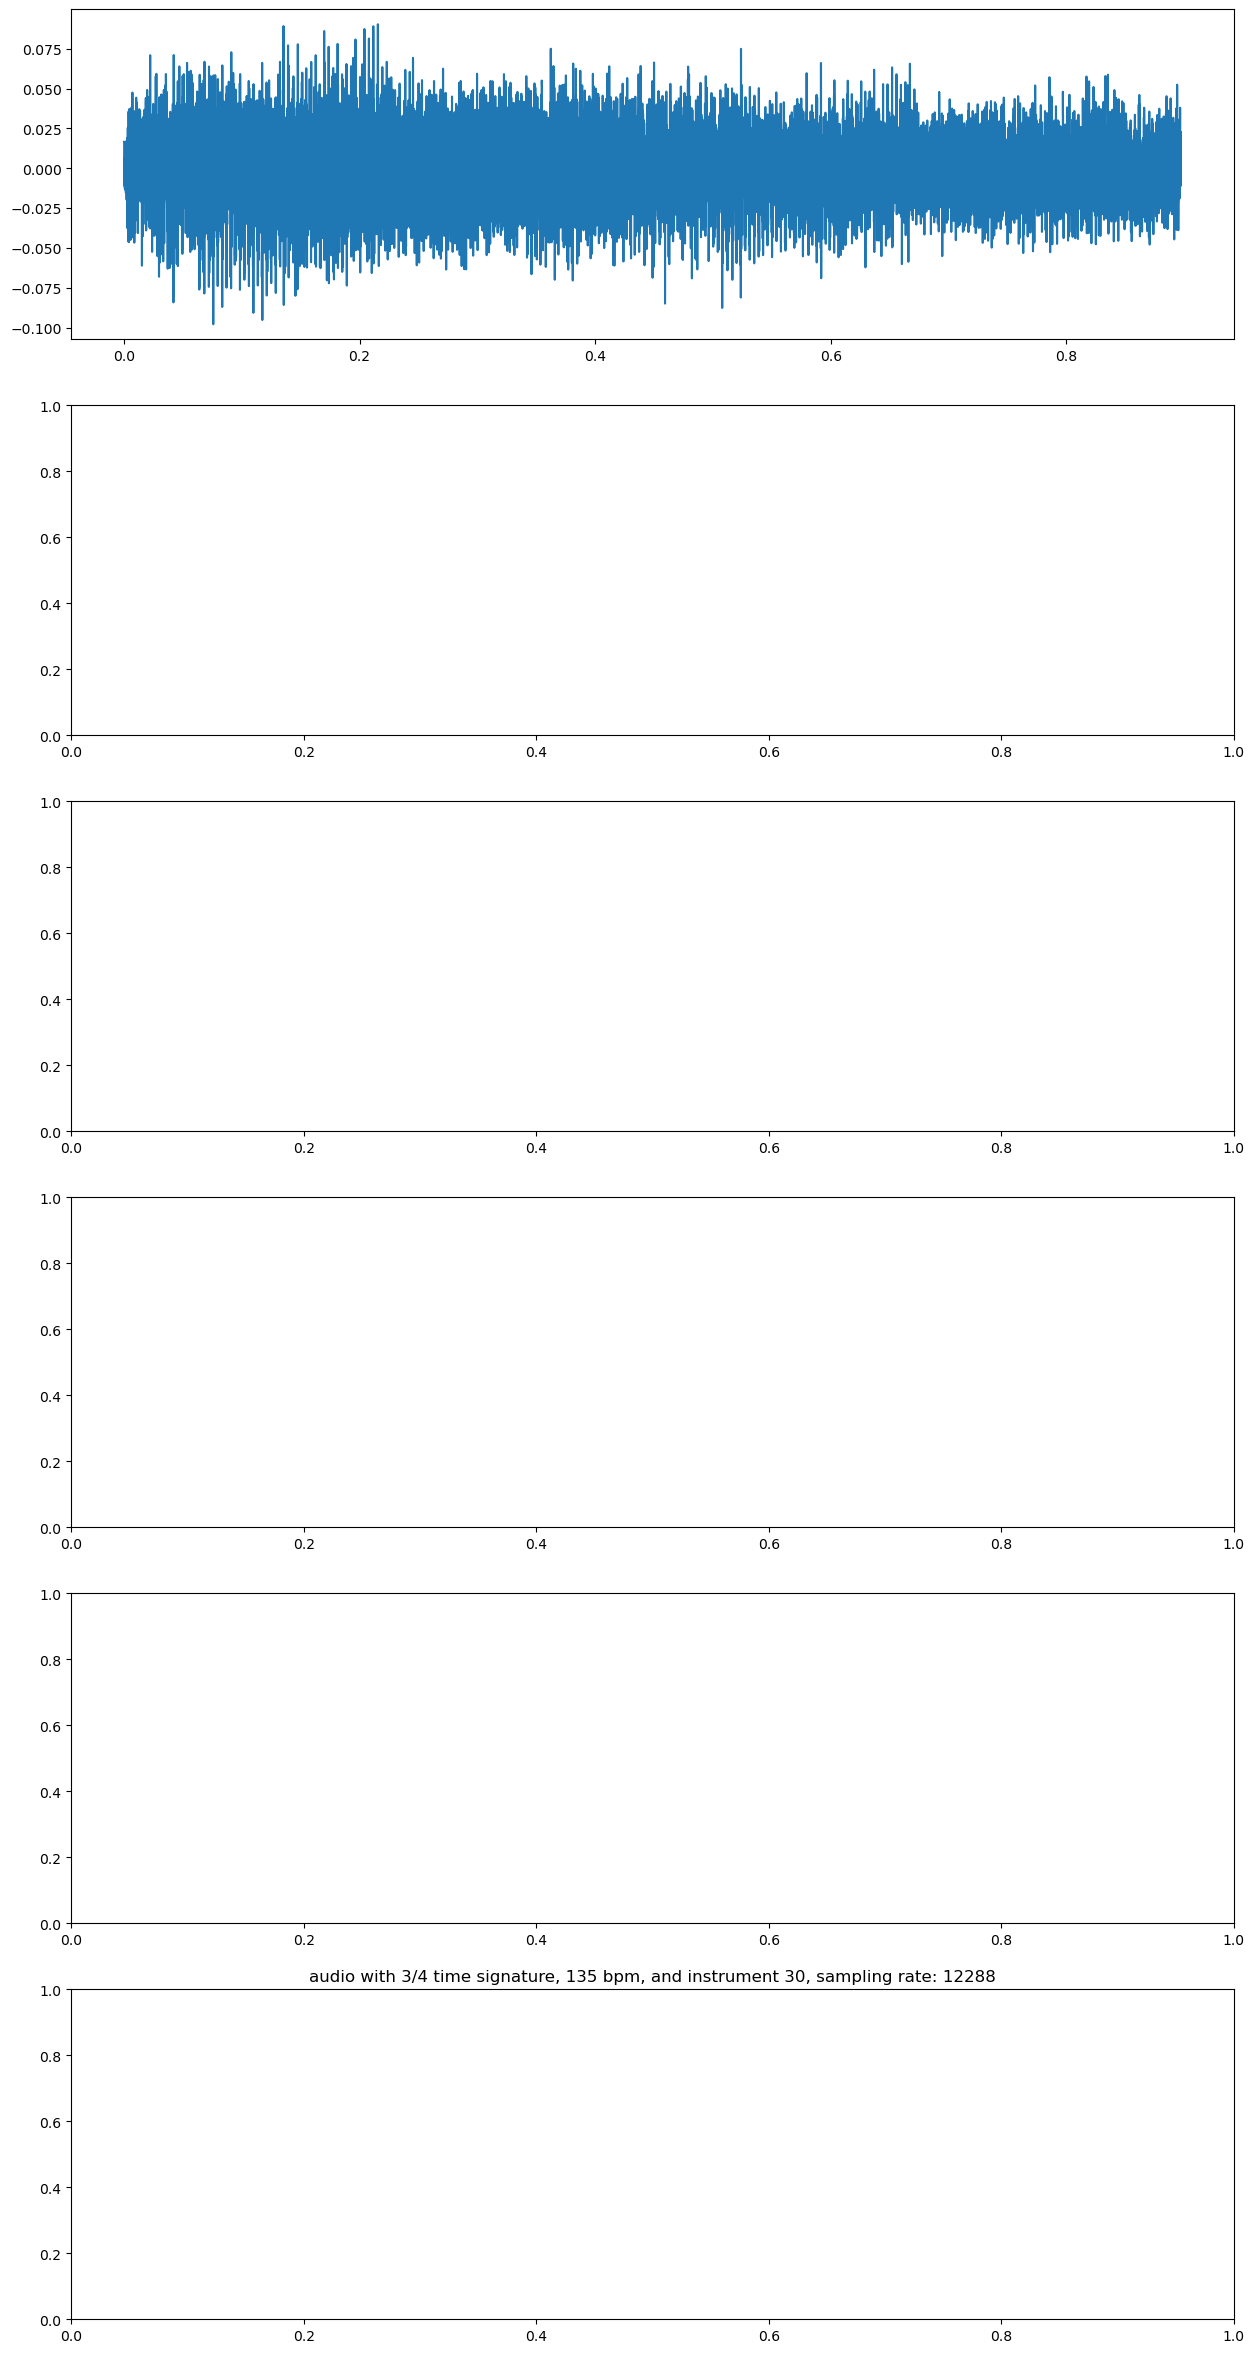

In [5]:
import librosa.display
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy.signal import find_peaks
from scipy.signal import peak_widths

def autocorrelate_tempogram(onset_strength, max_lag=None):
    # Step 1: Normalize the onset strength
    onset_mean = np.mean(onset_strength)
    onset_std = np.std(onset_strength) + 1e-8  # Adding a small constant to avoid division by zero
    onset_normalized = (onset_strength - onset_mean) / onset_std
    
    # Step 2: Apply a Hann window
    window = np.hanning(len(onset_normalized))
    onset_windowed = onset_normalized * window
    
    # Step 3: Compute the autocorrelation
    if max_lag is None:
        max_lag = len(onset_strength)
    autocorr = np.correlate(onset_windowed, onset_windowed, mode='full')[len(onset_strength)-1:len(onset_strength)+max_lag-1]
    
    return autocorr

def compute_onset_strength(y, sr):
    # Compute the STFT magnitude
    hop_length = int(sr * 0.01)  # roughly 1% of the sample rate. For 22kHz, this would be around 220.
    hop_length = min(512, hop_length)  # put an upper limit if you want

    # Set the window length as a multiple of hop length
    win_length = int(2 * hop_length)  # or 4 * hop_length

    # Using a Hann window explicitly
    D = np.abs(librosa.stft(y, window='hann'))
    
    # Compute the first-order difference
    diff = np.diff(D, axis=1)
    
    # Keep only the positive part of the difference (similar to half-wave rectification)
    diff = np.maximum(0, diff)
    
    # Sum across frequencies
    onset_strength = np.sum(diff, axis=0)
    
    return onset_strength

def find_fwhm(data, peak_index):
    half_max = data[peak_index] / 2
    left_idx = peak_index
    right_idx = peak_index
    
    # search to the left of the peak
    while left_idx > 0 and data[left_idx] >= half_max:
        left_idx -= 1
    
    # search to the right of the peak
    while right_idx < len(data) - 1 and data[right_idx] >= half_max:
        right_idx += 1
    
    # if the half_max level is not reached on either side of the peak, return a width of 0
    if data[left_idx] > half_max or data[right_idx] > half_max:
        return 0  
    
    return right_idx - left_idx

def calculate_peak_area(data, left_idx, right_idx):
    # Assuming data is non-negative
    return np.sum(data[left_idx:right_idx + 1])


def plot_tempo_extraction(y, sr, file_path):
    fig, axs = plt.subplots(6, 1, figsize=(15, 30))
    
    org_sr = sr
    tsr = 1024*12
    y = librosa.resample(y=y, orig_sr=sr, target_sr=tsr)
    sr = tsr
    
    time_signature = file_path.split('/')[-2].replace('_', '/')
    instrument, bpm_true, duration, noise = extract_bpm_and_instrument(file_path)  # Assuming you have this function
    print(f"time signature: {time_signature} BPM:{bpm_true} Noise:{noise} sampling rate: {sr} ", end='\r')
    plt.title(f'audio with {time_signature} time signature, {bpm_true} bpm, and instrument {instrument}, sampling rate: {sr}')
    
    bpm_true = int(bpm_true)
    
    # 1. Raw Audio
    librosa.display.waveshow(y, sr=sr, ax=axs[0])
    axs[0].set_title(f'raw audio with {time_signature} time signature, {bpm_true} bpm, and instrument {instrument}')
    axs[0].set_xlim([0, len(y) / sr])

    # 2. STFT Magnitude
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', ax=axs[1])
    axs[1].set_title("STFT Magnitude Spectrum")
    axs[1].set_xlim([0, len(y) / sr])


    # 3. Mel Spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    t = librosa.frames_to_time(np.arange(mel_spectrogram.shape[1]), sr=sr)  # based on the resampled sr
    librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), y_axis='mel', x_axis='time', x_coords=t, ax=axs[2])
    axs[2].set_title('Mel spectrogram')
    axs[2].set_xlim([0, len(y) / sr])


    # 4. Spectral Flux (onset strength)
    skip = 1
    onset_strength = compute_onset_strength(y=y, sr=sr)
    onset_times = librosa.frames_to_time(librosa.onset.onset_detect(onset_envelope=onset_strength, sr=sr))
    onset_times_adjusted = onset_times * (org_sr / sr)
    axs[3].vlines(onset_times_adjusted, 0, np.max(onset_strength), color='r', alpha=0.9, linestyle='--')

    t_onset = librosa.frames_to_time(np.arange(len(onset_strength)), sr=sr)  # based on the resampled sr
    axs[3].plot(t_onset, onset_strength, label="Onset Strength")
    axs[3].set_title("Spectral Flux with Onset Times")
    axs[3].set_xlim([0, len(y) / sr])

    # 5. Autocorrelation Tempogram
    hop_length = 512
    autocorr_tempogram = autocorrelate_tempogram(onset_strength)
    # normalize to range [0, 1]
    autocorr_tempogram = (autocorr_tempogram - np.min(autocorr_tempogram)) / (np.max(autocorr_tempogram) - np.min(autocorr_tempogram))
    lag_times = np.arange(len(autocorr_tempogram)) * hop_length / sr
    bpm_values = 60.0 / lag_times[skip:]
    valid_bpm_range = (bpm_values > 30) & (bpm_values < 220)
    valid_bpm_values = bpm_values[valid_bpm_range]
    valid_tempogram = autocorr_tempogram[skip:][valid_bpm_range]
    estimated_bpm = valid_bpm_values[np.argmax(valid_tempogram)]
    
        # Step 1: Find peaks
    peaks, _ = find_peaks(valid_tempogram, height=0.3)
    widths, width_heights, left_ips, right_ips = peak_widths(valid_tempogram, peaks, rel_height=0.5)
    
    widest_peak_index = np.argmax(widths)
    estimated_bpm_widest_peak = valid_bpm_values[peaks[widest_peak_index]]
    print(estimated_bpm_widest_peak)
    
    #axs[4].plot(autocorr_tempogram, label="Autocorrelation Tempogram", color='r')
    axs[4].plot(valid_bpm_values, valid_tempogram, label="Tempogram", color='g')
    axs[4].axvline(estimated_bpm, color='r', linestyle='--', label=f'Estimated BPM argmax: {estimated_bpm:.2f}')
    axs[4].axvline(estimated_bpm_widest_peak, color='g', linestyle='--', label=f'Estimated BPM FWHM: {estimated_bpm:.2f}')
    
        # New Code: Plot all detected peaks
    for peak_index in peaks:
        bpm_value_at_peak = valid_bpm_values[peak_index]
        axs[4].axvline(bpm_value_at_peak, color='b', linestyle='--', alpha=0.1)  # Blue dashed lines for all peaks

    axs[4].set_title("Autocorrelation Tempogram" + f'Estimated BPM: {estimated_bpm:.2f}' + f"widest peak : {estimated_bpm_widest_peak}")
    

    # 6. Librosa's Tempogram
    tempogram = librosa.feature.tempogram(onset_envelope=onset_strength, sr=sr)
    librosa.display.specshow(tempogram, sr=sr, x_axis='time', y_axis='tempo', cmap='magma', ax=axs[5])
    bpm = librosa.core.tempo_frequencies(tempogram.shape[0], hop_length=512, sr=sr)
    #bpm = bpm[skip:]
    #mean_tempogram = np.mean(tempogram, axis=1)
    mean_tempogram = np.mean(tempogram, axis=1)
    estimated_bpm_tempogram = bpm[np.argmax(mean_tempogram)]
    tempo, beat_times = librosa.beat.beat_track(y=y, sr=sr)
    axs[5].axhline(estimated_bpm_tempogram, color='r', linestyle='--', label=f'Estimated BPM: {estimated_bpm_tempogram:.2f}, librosa={tempo}')
    axs[5].axhline(bpm_true, color='g', linestyle='--', label=f'Correct BPM: {bpm_true:.2f}')
    axs[5].set_title(f'Tempogram Estimated BPM: {estimated_bpm_tempogram:.2f}, librosa={tempo}, true={bpm_true:.2f}')
    axs[5].set_xlim([0, len(y) / sr])
    

    
    plt.tight_layout()
    plt.show()
    
    
item_no_widget = widgets.IntSlider(min=0, max=len(training_data)-1, value=0, step=1, continuous_update=False, description="Item No.")

def wrapper(item_no):
    y = training_data[item_no][0]
    sr = training_data[item_no][1]
    file_path = training_data[item_no][2]
    plot_tempo_extraction(y, sr, file_path)

widgets.interactive(wrapper, item_no=item_no_widget)

In [6]:
#Initialize some global variables to remember state
last_item_index = -1
last_onset_strengths = {'1/4': None, '2/4': None, '3/4': None, '4/4': None, '5/4': None, '7/8': None}

def interactive_LIF(item_index, tau_m=6.0, v_rest=0.0, v_threshold=0.7, v_reset=0.2, r_m=0.9, dt=10.0, adaptive_increase=0.0, refractory_period=1):
    global last_item_index, last_onset_strengths
    
    print(f"item index={item_index}, last_item_index={last_item_index}", end='\r')
        
    fig, axs = plt.subplots(3, 2, figsize=(16, 12))
    
    # Create a title string that includes LIF parameters
    title_str = (f"LIF Parameters:\n"
                 f"tau_m={tau_m}, v_rest={v_rest}, v_threshold={v_threshold}, v_reset={v_reset},\n"
                 f"r_m={r_m}, dt={dt}, adaptive_increase={adaptive_increase}, refractory_period={refractory_period}")
    fig.suptitle(title_str, fontsize=12)
    
    
    for ax, (time_sig, data) in zip(axs.flatten(), [('1/4', training_data_1_4), ('2/4', training_data_2_4), ('3/4', training_data_3_4), ('4/4', training_data_4_4), ('5/4', training_data_5_4), ('7/8', training_data_7_8)]):
        
        if  last_item_index != item_index or last_onset_strengths[time_sig] is None:
            y, sr, file_path = data[item_index]
            # Apply a short fade-in
            # fade_in_time = 0.3  # in seconds
            # fade_in_samples = int(fade_in_time * sr)
            # fade_curve = np.linspace(0, 1, fade_in_samples)
            # y[:fade_in_samples] = y[:fade_in_samples] * fade_curve
            
            print("calculating onset strength", end='\r')
            onset_strength = librosa.onset.onset_strength(y=y, sr=sr)
            last_onset_strengths[time_sig] = onset_strength
        else:
            onset_strength = last_onset_strengths[time_sig]
        
        onset_strength = onset_strength[20:]
        onset_strength_normalized = (onset_strength - np.min(onset_strength)) / (np.max(onset_strength) - np.min(onset_strength))

        # Your plotting logic here using ax for plotting
        lif_neuron = LIFNeuron(tau_m=tau_m, v_rest=v_rest, v_threshold=v_threshold, v_reset=v_reset, r_m=r_m, dt=dt, adaptive_increase=adaptive_increase, refractory_period=refractory_period)
        lif_spikes, lif_potentials = generate_lif_spikes(onset_strength_normalized, lif_neuron)  # Note the second returned value
        spike_count = np.sum(lif_spikes)
        # Find indices where spikes occur
        spike_indices = np.where(lif_spikes > 0)[0]
        ax.vlines(spike_indices, ymin=1.05, ymax=1.1, color='r', label='LIF Spike Train')
        ax.plot(onset_strength_normalized, label='Onset Strength', alpha=0.7)
        ax.plot(lif_spikes, label='Onset spikes', alpha=0.7)
        ax.plot(lif_potentials, label='Membrane Potential', linestyle='--', color='g')  # Plot the potentials
        ax.set_title(f'Onset Strength {time_sig} with LIF Spike Train, Spike Count: {int(spike_count)}')
        ax.legend(loc='center right')
    
    if item_index != last_item_index:
        last_item_index = item_index
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for the suptitle    
    # plt.show()
    # plot the parameters of the lif neuron
    plt.savefig('LIF_spiketrain_compare_adaptive.png')


max_index = min(len(training_data_1_4), len(training_data_2_4), len(training_data_3_4), len(training_data_4_4)) - 1

if widgets is not None:
    widgets.interact(
            interactive_LIF,
            item_index=widgets.IntSlider(min=0, max=max_index, value=0, step=1, continuous_update=False, description="Item Index"),
            tau_m=widgets.FloatSlider(min=1.0, max=10.0, value=6.0, step=0.1, continuous_update=True, description="tau_m"),
            v_rest=widgets.FloatSlider(min=0.0, max=1.0, value=0.0, step=0.1, continuous_update=True, description="v_rest"),
            v_threshold=widgets.FloatSlider(min=0.0, max=1.0, value=0.7, step=0.1, continuous_update=True, description="v_threshold"),
            v_reset=widgets.FloatSlider(min=0.0, max=1.0, value=0.2, step=0.1, continuous_update=True, description="v_reset"),
            r_m=widgets.FloatSlider(min=0.1, max=1.0, value=0.9, step=0.1, continuous_update=True, description="r_m"),
            dt=widgets.FloatSlider(min=0.1, max=100.0, value=10.0, step=0.1, continuous_update=True, description="dt"),
            adaptive_increase=widgets.FloatSlider(min=0.0, max=1.0, value=0.0, step=0.1, continuous_update=True, description="adaptive threshold increase"),
            refractory_period=widgets.IntSlider(min=0, max=10, value=1, step=1, continuous_update=True, description="refractory period"),
        );

interactive(children=(IntSlider(value=0, continuous_update=False, description='Item Index', max=4), FloatSlide…